In [57]:
## Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

import spacy
import re

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

## A One-Stop Shop for Data Cleaning

Let's join together everything we did to our dataset in the Data Cleaning & EDA notebook in one function, and run our datasets through them so that we're ready to get to modeling.

In [58]:
def clean_my_data(df1, df2):
    
    ### Joining both DataFrames but only in the columns they have in common, dropping Unnamed: 0 column
    df1.drop(columns = 'Unnamed: 0', inplace=True)
    df2.drop(columns = 'Unnamed: 0', inplace=True)
    reddit_df = pd.concat([df1, df2],join='inner', ignore_index=True)
    
    # Filling in NaNs in selftext with empty strings
    reddit_df['selftext'].fillna("", inplace=True)
    
    ## Getting rid of html links
    reddit_df['selftext'] = reddit_df['selftext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
    
    ## Getting rid of a handful of regular expressions
    reddit_df['selftext'].replace("&amp;", "", regex=True, inplace=True)
    reddit_df['selftext'].replace("#x200B;", "", regex=True, inplace=True)
    reddit_df['selftext'].replace("nbsp;", "", regex=True, inplace=True)
    
    ### New Columns pertaining to length
    reddit_df['tt_ch_length'] = reddit_df['title'].str.len() ## Title character length
    reddit_df['st_ch_length'] = reddit_df['selftext'].str.len() ## Selftext carachter length
    
    reddit_df["tt_wc"] = [len(x) for x in reddit_df['title'].str.split(" ")] ## Title wordcount
    reddit_df["st_wc"] = [len(x) for x in reddit_df['selftext'].str.split(" ")] ## Selftext wordcount
    reddit_df.loc[reddit_df['st_ch_length'] == 0, "st_wc"] = 0 # Making sure empty strings aren't counted in wordcount   
    
    
    ##### More stuff I might need to do
    reddit_df['fulltext'] = reddit_df['title'] + " " + reddit_df['selftext'] ## Column made up of Title-Selftext combinations as a single document per row
    reddit_df['is_nhl'] = (reddit_df['subreddit'] == 'nhl').astype(int) # Our dependent variable - is the post from the NHL Subreddit?
    
    
    return reddit_df

Let's test this function!

In [59]:
nba_df = pd.read_csv('../datasets/nba.csv')
nhl_df = pd.read_csv('../datasets/nhl.csv')

In [60]:
reddit_df = clean_my_data(nba_df, nhl_df)

In [61]:
reddit_df.shape

(6000, 87)

In [62]:
reddit_df.fulltext.drop_duplicates().size

5903

There's only 97 rows that have repeated title-selftext combinations. 
I think we can safely drop these duplicates.

In [63]:
## Dropping rows with duplicated fulltext
reddit_df = reddit_df[~reddit_df.fulltext.duplicated()]

During Data Cleaning & EDA, we noticed that not only do roughly half of all submissions have no text in their body (i.e. the 'selftext' feature). On top of this, we also noticed that there's submissions whose titles seem to be long enough to substitute for selftext in practical terms.

Given that we set out to classify submissions based on their text data, it thus makes intuitive sense to join titles and selftext together into a single document per submission. We can think of each document the way we might think of a college essay - the title is part of the text itself, so why not just join the two? This information is stored under the feature "fulltext" which will be vectorized in our models. This fulltext will serve as the corpus from which the independent variables in our models will be constructed.

Our dependent variable, on the other hand, will simply be a variable named "is_nhl" which takes the value of 1 when the subreddit corresponding to the submission in question is r/NHL and takes the value of 0 otherwise (i.e. r/NBA).

In [64]:
## Splitting data into train and test sets
X = reddit_df[['fulltext']]
y = reddit_df['is_nhl']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

We will leverage the spaCy library in order to process our documents and, along with the help of a new function, pull out those English words in our corpus that are not stop words (words such as "and" that are so common as to be useless) and rid them of unnecessary punctuation. 

In [65]:
# Downloading spacy english pipeline
spacy.cli.download('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [66]:
# Loading spacy english nlp object
nlp = spacy.load('en_core_web_md')

In [67]:
# Converting review text into SpaCy doc objects
X_train_nlp = X_train.applymap(nlp)
X_test_nlp = X_test.applymap(nlp) 

In [68]:
type(X_train_nlp)

pandas.core.frame.DataFrame

In [69]:
def get_relevant_words(doc):
    '''
    This function creates a string of tokens in a spacy doc that are not stop
    words or punctuation.
    
    Parameters
    ----------
    doc: A SpaCy doc object
    
    Returns
    -------
    A string that contain non-stop, non-puntuation words
    '''
    return " ".join([token.lemma_ for token in doc if (not token.is_stop) and (not token.is_punct)])

Having stripped our corpus of stop words and punctuation, we will now run it through a TfidVectorizer to get our sparse matrix of features and their corresponding TF-IDF measurements. We will fit the vectorizer to our training set and transform the same, while merely transforming the test set (we don't want our models "looking" at test data just yet).

In [70]:
# Convert training features into strings of relevant words and vectorize them
tfidf = TfidfVectorizer()
X_train_nlp_sparse = tfidf.fit_transform(X_train_nlp.applymap(get_relevant_words).iloc[:,0])

In [71]:
# Assemble vectorized entries into a DataFrame
X_train_tfidf = pd.DataFrame(X_train_nlp_sparse.todense(), columns=tfidf.get_feature_names_out())

In [72]:
# Repeating nlp for testing dataset
X_test_nlp_sparse = tfidf.transform(X_test_nlp.applymap(get_relevant_words).iloc[:,0])
X_test_tfidf = pd.DataFrame(X_test_nlp_sparse.todense(), columns=tfidf.get_feature_names_out())

In [73]:
X_train_tfidf.shape # That's a whole lotta features!

(4427, 11011)

# Let's Get to Modeling

Now that I have a big matrix of tokens to build classification models off of, let's go through the basics of each of the three types of model I'm going to try out:

- Logistic Regression
- k-Nearest Neighbors
- Random Forest

## Logistic Regression

A logistic model models the probability of an event taking place (in this case, whether or not a given submission came from r/NHL) by having the log-odds of the event be a linear combination of one or more independent variables. A logistic regression estimates the parameters of said logistic model.

## k-Nearest Neighbors

The k-Nearest Neighbors algorithm, on the other hand, is a non-parametric supervised learning method that is used for classification. The algorithm essentially takes a given observation and assigns it the majority class (i.e. r/NBA or r/NHL, 0 & 1) of its k-nearest neighbors (k being the number of neighbors that are nearest).  

## Random Forest

Decision Trees are a decision support tool that use a tree-like model of decisions and their possible consequences, or in this case, features and their possible resulting classifications. These decision trees are leveraged in a supervised learning approach that results in a predictive model whose 'leaves' represent class labels and 'branches' represent conjunctions of features that result in said class labels.

However, decision trees have a tendency to overfit to training data. An ensemble training method called a Random Forest corrects for this by constructing a multitude of decision trees during training. The classification we ascribe to a  new observation is thus the class selected by most trees in the random forest.

-----

In our first modeling run, we'll simply use the features we cooked up earlier and see how each model does. Afterwards, we'll leverage GridSearch to see if we can refine the models involved.

### Baseline Model

In this case, our classification is binary. A submission either came from r/NBA or r/NHL. Given the datasets we worked with had the same number of rows, we should expect a baseline result of 50%. That is to say, if we simply *guessed* which subreddit a given post came from, we'd be able to guess r/NHL and be correct about 50% of the time.

# Model 1: Logistic Regression

In [78]:
# Instantiating and training a Logistic Regressor
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train);
# Printing out train and test accuracy scores
logreg.score(X_train_tfidf, y_train), logreg.score(X_test_tfidf, y_test)

(0.9760560198780213, 0.9424119241192412)

That's wonderful. Looks like we got scores of 97% and 93% for our train and test sets, respectively.

In [79]:
# Checking the majority class
y_test.value_counts(normalize=True)

1    0.50271
0    0.49729
Name: is_nhl, dtype: float64

As we expected, the split between r/NBA and r/NHL posts in our test set is practically 50/50 (good thing we stratified the data when we split Train and Test).

A Confusion Matrix is a handy visual tool that allows us to see how often our predicted labels turned out to be correct. Let's take a look at the Confusion Matrix corresponding to our Logistic Regression.

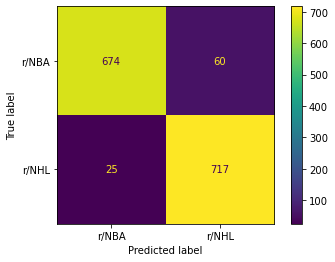

In [80]:
# Printing out confusion matrix for logistic regression
ConfusionMatrixDisplay.from_estimator(logreg, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

Looks like we did great! We got the vast majority of our predictions right!

# Model 2: k-Nearest Neighbors

In [81]:
# Instantiating and training a generic k-Nearest Neighbors classifier
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf, y_train);
# Prining out train and test accuracy scores for kNN
knn.score(X_train_tfidf, y_train), knn.score(X_test_tfidf, y_test)

(0.5389654393494466, 0.5115176151761518)

Looks like our model did not overfit to the training set, but it did terribly. It's practically as good as simply guessing.

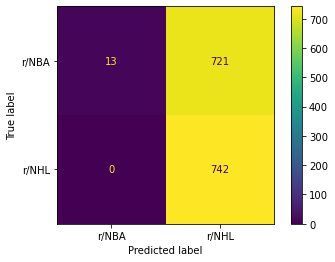

In [82]:
# Printing out confusion matrix for k-NearestNeighbors
ConfusionMatrixDisplay.from_estimator(knn, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

What's odd here is that our model simply guessed that practically all posts belonged in r/NHL. That's curious. Perhaps a different set of parameters for our model (such as different k rather than the default k=5) would have yielded better results.

# Model 3: Random Forest

In [83]:
# Instantiating and fitting random forest classifier
rfc = RandomForestClassifier(max_depth=100)
rfc.fit(X_train_tfidf, y_train);

In [84]:
# Displaying train and test scores
rfc.score(X_train_tfidf, y_train), rfc.score(X_test_tfidf, y_test)

(0.9606957307431669, 0.924119241192412)

Our generic Random Forest classifier, on the other hand, did pretty well! It's a close second to our logistic regression model, with scores of 95% vs 92% on our Training and Test sets respectively. The distance between these two scores suggests little to no overfitting.

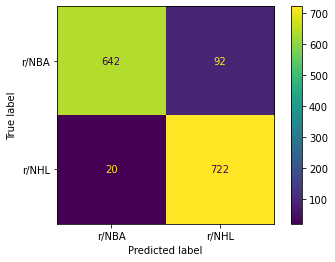

In [85]:
# Showing confusion matrix for random forest
ConfusionMatrixDisplay.from_estimator(rfc, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

# But What if We Used GridSearch?

GridSearchCV allows us to iterate over a set of parameters (rather than the default parameter values we opted for earlier) in order to test out several different iterations of the same models and see which combination of parameters yields the best model. Let's try iterating over a handful of parameters and see if we can't improve on our earlier results.

## Applying GridSearch on Our Random Forest Model

In [90]:
# Grid searching over relevant parameters for random forest
params = {
    'max_depth':[100],
    'ccp_alpha':[0,0.5],
    'n_estimators':[20, 50],
    'max_features':[0.05, 0.1, 0.2,0.5]
}
grid_rfc = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)

In [91]:
# Fitting random forest models
est = grid_rfc.fit(X_train_tfidf, y_train)

In [92]:
# Inspecting best fit parameters
est.best_params_

{'ccp_alpha': 0, 'max_depth': 100, 'max_features': 0.05, 'n_estimators': 50}

In [93]:
# Displaying train and test score for random forest
est.score(X_train_tfidf, y_train), est.score(X_test_tfidf, y_test)

(0.9625028235825616, 0.9098915989159891)

That's interesting, our top Random Forest model took spectacularly well to the training data.. but got practically the same score on the test data as the first time around. Tuning the model further seems to have simply overfit it to the training data.

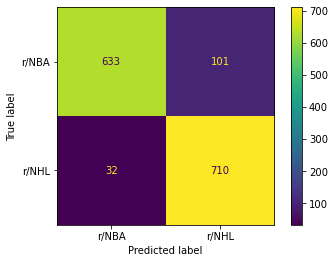

In [94]:
# Displaying confusion matrix for random forest gridsearch
ConfusionMatrixDisplay.from_estimator(grid_rfc, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

That's really funny - this took 20min to run and somehow yielded marginally worse results! A great example of why you should be careful when you pick your parameters. In a future iteration, I'd like to refine these.

## Using Gridsearch on our kNN Model

In [95]:
# Grid searching over relevant parameters for kNN
params = {
    'n_neighbors':[3, 5, 7, 11],
    'weights':['uniform','distance'],
    'p':[1, 2]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)

In [96]:
# Fitting kNN models
grid_knn.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [97]:
# Displaying train and test score for kNN
grid_knn.score(X_train_tfidf, y_train), grid_knn.score(X_test_tfidf, y_test)

(1.0, 0.5521680216802168)

Our KNN model, even under GridSearch, remains weak, (though this time it is completely fitted to the training data) and is making the same kind of mistake.

It is also worth mentioning that this model took a long time to process. The reason for this (and, I suspect, why it does so poorly) is that the set of features we're feeding the model has a high degree of dimensionality. The distance between any one point and its k-nearest neighbors is measured along thousands of axes here. It's computationally expensive and it gets you very little in terms of predictive power. 

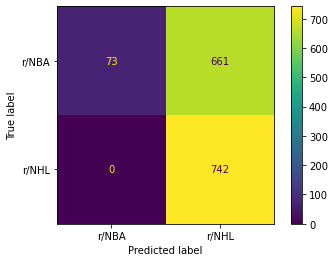

In [99]:
# Displaying confusion matrix for kNN gridsearch
ConfusionMatrixDisplay.from_estimator(grid_knn, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

## Using Gridsearch on Logistic Regression

In [100]:
# Grid searching over relevant parameters for logreg
params = {
    'C':[0.01,0.1,1,10,100]
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=1_000), params, n_jobs=-1)

In [101]:
# Fitting logreg models
grid_logreg.fit(X_train_tfidf, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [102]:
# Displaying train and test score for logreg
grid_logreg.score(X_train_tfidf, y_train), grid_logreg.score(X_test_tfidf, y_test)

(0.9986446803704541, 0.9478319783197832)

Here, we see something similar to what we observed for our GridSearched Random Forest model. We barely improved on our original testing set score of 93% to... 94.3%. It seems GridSearch just doesn't have much juice here (OR we need to think of a better set of parameters to iterate over).

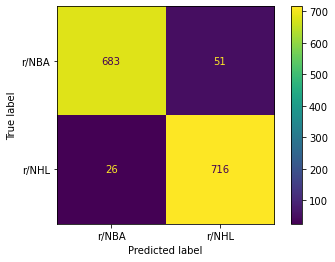

In [104]:
# Displaying confusion matrix for logreg gridsearch
ConfusionMatrixDisplay.from_estimator(grid_logreg, X_test_tfidf, y_test, display_labels=['r/NBA', 'r/NHL']);

It seems our most successful model is the Logistic Regression under GridSearch, but not by much compared to the original Logistic Regression.

How could we still make the model more powerful?

We've used stop words, but what if we lemmatized the words that inform the model. Would that improve our performance?

## Lemmatization

Lemmatization refers to the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's *lemma*, or dictionary form. 

For example, the set of words "dribble, dribbled, dribbling" could all be lemmatized as "dribble," which could then be assessed for its relative importance in our TfidVectorizer rather than have 3 different words assessed individually.

Let's see if lemmatizing the words in our corpus helps the performance of our top model - the Logistic Regression using TfidVectorizer under GridSearch.

## Logistic Regression with Lemmatized Words and TfidVectorizer under GridSearch

In [105]:
## Creating a class called LemmaTokenizer which will lemmatize the words in our corpus.
class LemmaTokenizer():

    def __init__(self):
        self.wnl = WordNetLemmatizer()
    
    def __call__(self, document):
        return [self.wnl.lemmatize(word) for word in word_tokenize(document)]

In [106]:
## Splitting original, cleaned data into train and test seets
X = reddit_df['fulltext']
y = reddit_df['is_nhl']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [107]:
X.shape, y.shape

((5903,), (5903,))

In [108]:
# Running TfidVectorizer with our LemmaTokenizer as our tokenizer
tfid_lemmas = TfidfVectorizer(tokenizer=LemmaTokenizer())

In [109]:
#Fit-Transforming Train and Transforming Test
X_train_lemmas = tfid_lemmas.fit_transform(X_train)
X_test_lemmas = tfid_lemmas.transform(X_test)

In [110]:
## Placing resulting train and test matrices in respective DataFrames
train_lemmas_df = pd.DataFrame(X_train_lemmas.A, columns = tfid_lemmas.get_feature_names_out())
test_lemmas_df = pd.DataFrame(X_test_lemmas.A, columns = tfid_lemmas.get_feature_names_out())

In [111]:
# Checking Shape of Each
train_lemmas_df.shape, test_lemmas_df.shape

((4427, 15668), (1476, 15668))

In [112]:
# Grid searching over relevant parameters for logreg
params = {
    'C':[0.01,0.1,1,10,100]
}

grid_logreg = GridSearchCV(LogisticRegression(max_iter=1_000), params, n_jobs=-1)

In [113]:
# Fitting logreg models
grid_logreg.fit(train_lemmas_df, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [114]:
# Displaying train and test score for logreg
grid_logreg.score(train_lemmas_df, y_train), grid_logreg.score(test_lemmas_df, y_test)

(0.997289360740908, 0.9295392953929539)

Once again, our "refinement" of the model yielded iffy results. We barely improved on our test set score (93.7%) and got a perfect score on the training data. We've overfitted the model to the training data.

That being said, 92.9% on the test set isn't a *bad* result, far from it. Our classification model does pretty well. Let's take a look at its corresponding confusion matrix.

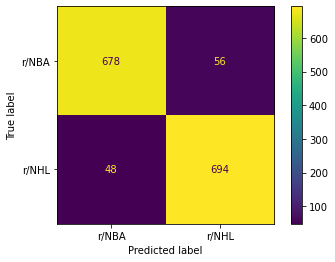

In [116]:
# Displaying confusion matrix for logreg gridsearch
ConfusionMatrixDisplay.from_estimator(grid_logreg, test_lemmas_df, y_test, display_labels=['r/NBA', 'r/NHL']);

Wonderful! Let's use this confusion matrix to calculate some classification metrics for our most successful model, the Logistic Regression under Gridsearch (our 2nd LR):

 - Accuracy (94.8%): Percentage of obsservations the model correctly predicted.
 - Misclassification Rate (5.2%): Percentage of observations the model incorrectly predicted.
 - Sensitivity (96.5%): Rate of True Positives vs All Positives (r/NHL)
 - Specificity (93.1%): Rate of True Negatives vs All Negatives (r/NBA)
 - Precision (93.4%): Rate of True Positives vs Predicted Positives (r/NHL)

All in a Day's Work!

In a future iteration of this project, I'd like to refine my GridSearch parameters to see if I can't meaningfully improve each model's performance on the test set. I was surprised by the degree to which, in this instance, GridSearch merely contributed to overfitting on the Train data with only marginal improvements on performance on the Test data. However, given our classification metrics, I'd say our Logistic Regression model did very well.